In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Predict Student Results/Code
!ls

/content/drive/MyDrive/Predict Student Results/Code
 Clean_data.ipynb    EDA.ipynb		        test.csv
 data_cleaning.csv  'EDA - part2.ipynb'         test_model_v1.zip
 Data.csv	    'EDA - Part 3 - DL.ipynb'   train.csv


In [3]:
!pip install --quiet shap==0.39.0
!pip install pytorch-tabnet

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)
from sklearn.utils import check_array

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

import shap

%matplotlib inline

sns.set_style('darkgrid')
pd. set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import glob
from joblib import Parallel, delayed
import scipy as sc
# pd.set_option('max_columns', 300)
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

import random

from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from pathlib import Path

In [6]:
SEED = 42

def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

random_seed(SEED)

In [7]:
data = pd.read_csv('data_cleaning.csv')

In [8]:
data

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,diem_ts,hoc_ky,dkhk,tbhk,tctl,tbtl,xlhv,diem_tn,ket_qua_tn,nam_tn
0,A06960,Kế toán doanh nghiệp,Nữ,0,3,A00,20.00,1,22,2.60,22.0,2.60,NaN,3.35,Tốt nghiệp Giỏi,4.0
1,A06961,Kế toán doanh nghiệp,Nữ,0,3,A00,20.00,1,22,2.50,19.0,2.50,NaN,2.55,Tốt nghiệp Khá,4.0
2,A06962,Kế toán doanh nghiệp,Nữ,0,3,A00,20.00,1,22,2.80,22.0,2.80,NaN,3.02,Tốt nghiệp Khá,4.0
3,A06963,Kế toán doanh nghiệp,Nam,0,3,A00,20.00,1,22,2.25,19.0,2.25,NaN,2.52,Tốt nghiệp Khá,4.0
4,A06964,Kế toán doanh nghiệp,Nam,0,3,A00,20.00,1,22,2.20,22.0,2.20,NaN,2.09,Tốt nghiệp Trung bình,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175831,A27495,Ngôn ngữ Anh,Nữ,0,1,D01,25.00,6,24,3.13,122.0,3.24,NaN,3.24,Tốt nghiệp Giỏi,4.0
175832,A27495,Ngôn ngữ Anh,Nữ,0,1,D01,25.00,7,3,2.33,131.0,3.18,NaN,3.24,Tốt nghiệp Giỏi,4.0
175833,A27497,Ngôn ngữ Anh,Nữ,0,1,D01,24.25,5,18,3.33,87.0,2.96,NaN,3.21,Tốt nghiệp Giỏi,4.0
175834,A27497,Ngôn ngữ Anh,Nữ,0,1,D01,24.25,6,21,3.57,108.0,3.09,NaN,3.21,Tốt nghiệp Giỏi,4.0


# Data Processing

In [9]:
data['doi_tuong'] = data['doi_tuong'].astype(str)
data['hoc_ky'] = data['hoc_ky'].astype(str)
data['xlhv'].fillna('Bình thường', inplace = True)

# # Mean fill
# def mean_fill(data, column):
#     col_mode = data[column].mean()
#     data[column].fillna(col_mode, inplace = True)

# mean_fill(data, 'diem_ts')
# mean_fill(data, 'tctl')

# # Label encoder 'id'(Có thể hiểu là MSSV)
# le = LabelEncoder()
# le.fit(data["id"])
# data["id"] = le.transform(data["id"])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175836 entries, 0 to 175835
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          175836 non-null  object 
 1   nganh       175836 non-null  object 
 2   gioi_tinh   175836 non-null  object 
 3   doi_tuong   175836 non-null  object 
 4   khu_vuc     175836 non-null  object 
 5   khoi_ts     175836 non-null  object 
 6   diem_ts     175357 non-null  float64
 7   hoc_ky      175836 non-null  object 
 8   dkhk        175836 non-null  int64  
 9   tbhk        175836 non-null  float64
 10  tctl        175802 non-null  float64
 11  tbtl        175836 non-null  float64
 12  xlhv        175836 non-null  object 
 13  diem_tn     175836 non-null  float64
 14  ket_qua_tn  175836 non-null  object 
 15  nam_tn      175836 non-null  float64
dtypes: float64(6), int64(1), object(9)
memory usage: 21.5+ MB


In [11]:
# scales = data.drop(['diem_ts', 'dkhk', 'tctl'], axis = 1).columns.to_list()
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(data[scales])

In [11]:
categorical_columns = []
categorical_dims =  {}

for col in data.columns[data.dtypes == object]:
    print(col, data[col].nunique())
    l_enc = LabelEncoder()
    data[col] = l_enc.fit_transform(data[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in data.columns[(data.dtypes == 'float64') | (data.dtypes == 'int64')]:
    data[col].fillna(data[col].mean(), inplace=True)

id 24332
nganh 12
gioi_tinh 2
doi_tuong 7
khu_vuc 4
khoi_ts 6
hoc_ky 9
xlhv 3
ket_qua_tn 4


In [12]:
data

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,diem_ts,hoc_ky,dkhk,tbhk,tctl,tbtl,xlhv,diem_tn,ket_qua_tn,nam_tn
0,6708,3,1,0,3,0,20.00,0,22,2.60,22.0,2.60,1,3.35,0,4.0
1,6709,3,1,0,3,0,20.00,0,22,2.50,19.0,2.50,1,2.55,1,4.0
2,6710,3,1,0,3,0,20.00,0,22,2.80,22.0,2.80,1,3.02,1,4.0
3,6711,3,0,0,3,0,20.00,0,22,2.25,19.0,2.25,1,2.52,1,4.0
4,6712,3,0,0,3,0,20.00,0,22,2.20,22.0,2.20,1,2.09,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175831,24330,6,1,0,0,3,25.00,5,24,3.13,122.0,3.24,1,3.24,0,4.0
175832,24330,6,1,0,0,3,25.00,6,3,2.33,131.0,3.18,1,3.24,0,4.0
175833,24331,6,1,0,0,3,24.25,4,18,3.33,87.0,2.96,1,3.21,0,4.0
175834,24331,6,1,0,0,3,24.25,5,21,3.57,108.0,3.09,1,3.21,0,4.0


In [13]:
target_feat = np.array(data['ket_qua_tn'])
# Remove the target from the features
# axis 1 refers to the columns
features= data.drop(['ket_qua_tn', 'id'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [14]:
# y = data['ket_qua_tn'] 
# X = data.drop(['ket_qua_tn', 'id'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(features, target_feat, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print("X train shape: ", X_train.shape)
print("X validation shape: ", X_val.shape)
print("X test shape: ", X_test.shape)
print("Y train shape: ", y_train.shape)
print("Y validation shape: ", y_val.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (112534, 14)
X validation shape:  (28134, 14)
X test shape:  (35168, 14)
Y train shape:  (112534,)
Y validation shape:  (28134,)
Y test shape:  (35168,)


In [15]:
print(type(X_train))

<class 'numpy.ndarray'>


In [16]:
unused_feat = ['id']
target = 'ket_qua_tn'

features = [ col for col in data.columns if col not in unused_feat + [target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

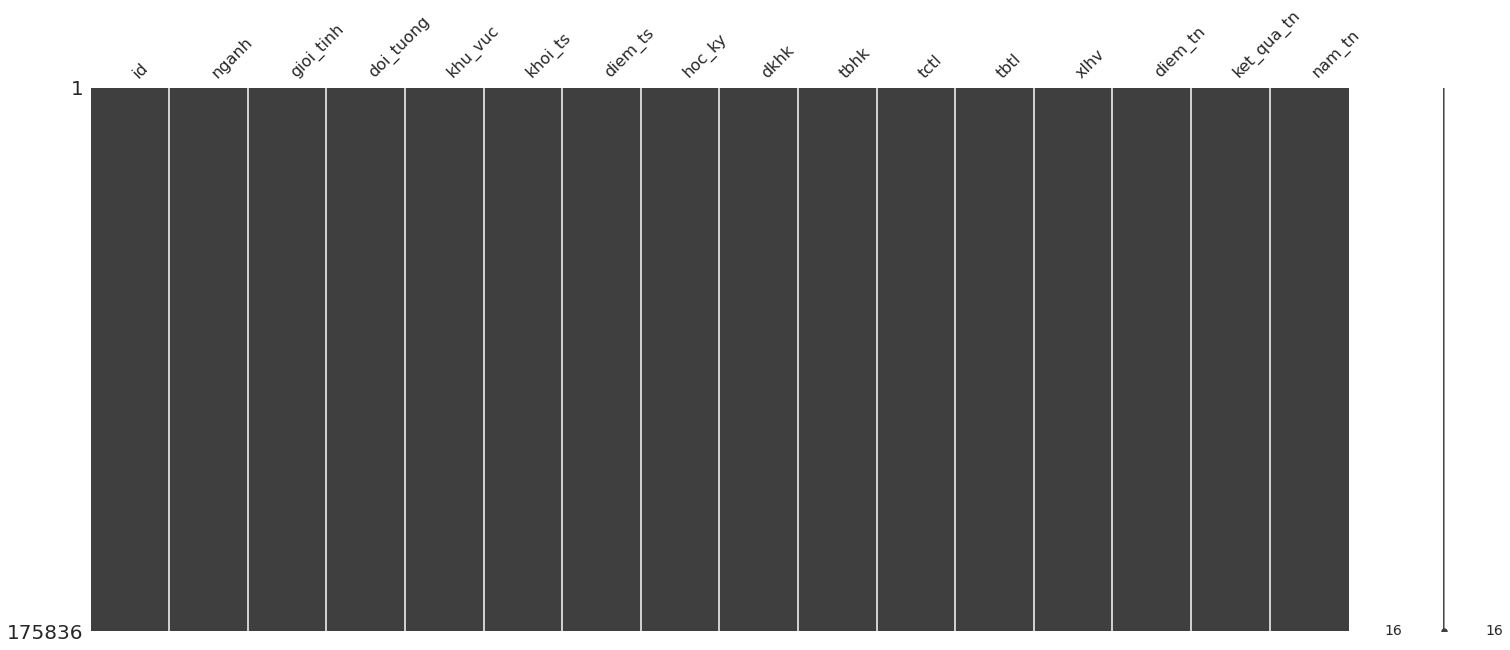

In [17]:
msno.matrix(data)

In [18]:
class F1Weighted(Metric):
    def __init__(self):
        self._name = "f1_weighted"
        self._maximize = False

    def __call__(self, y_true, y_score):
        return f1_score(y_true, np.argmax(y_score,axis=1), average = 'weighted')

In [20]:
# def my_loss_fn(y_pred, y_true):
#     """
#     Dummy example similar to using default torch.nn.functional.cross_entropy
#     """
#     softmax_pred = torch.nn.Softmax(dim=-1)(y_pred)
#     logloss = (1-y_true)*torch.log(softmax_pred[:,0])
#     logloss += y_true*torch.log(softmax_pred[:,1])
#     return -torch.mean(logloss)

In [19]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cuda


In [20]:
clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'valid'],
        eval_metric=['f1_weighted'],
        max_epochs= 50,
        patience=10,
        batch_size=256, virtual_batch_size=128,
        num_workers=0,
        # loss_fn = my_loss_fn,
        drop_last=False
    )

epoch 0  | loss: 0.27761 | train_f1_weighted: 0.95108 | valid_f1_weighted: 0.94743 |  0:00:23s
epoch 1  | loss: 0.14956 | train_f1_weighted: 0.95874 | valid_f1_weighted: 0.957   |  0:00:48s
epoch 2  | loss: 0.12797 | train_f1_weighted: 0.97823 | valid_f1_weighted: 0.9769  |  0:01:11s
epoch 3  | loss: 0.11606 | train_f1_weighted: 0.94247 | valid_f1_weighted: 0.93994 |  0:01:36s
epoch 4  | loss: 0.11398 | train_f1_weighted: 0.98033 | valid_f1_weighted: 0.97854 |  0:02:01s
epoch 5  | loss: 0.11056 | train_f1_weighted: 0.97996 | valid_f1_weighted: 0.97834 |  0:02:25s
epoch 6  | loss: 0.11123 | train_f1_weighted: 0.95742 | valid_f1_weighted: 0.95512 |  0:02:48s
epoch 7  | loss: 0.10174 | train_f1_weighted: 0.97573 | valid_f1_weighted: 0.97393 |  0:03:11s
epoch 8  | loss: 0.09704 | train_f1_weighted: 0.97616 | valid_f1_weighted: 0.9746  |  0:03:34s
epoch 9  | loss: 0.10689 | train_f1_weighted: 0.97612 | valid_f1_weighted: 0.97417 |  0:03:58s
epoch 10 | loss: 0.09873 | train_f1_weighted: 0.97

In [ ]:
# tabnet_params = dict(
#     n_d = 32,
#     n_a = 32,
#     n_steps = 3,
#     gamma = 1.3,
#     lambda_sparse = 0,
#     optimizer_fn = optim.Adam,
#     optimizer_params = dict(lr = 1e-2, weight_decay = 1e-5),
#     mask_type = "entmax",
#     scheduler_params = dict(
#         mode = "min", patience = 5, min_lr = 1e-5, factor = 0.9),
#     scheduler_fn = ReduceLROnPlateau,
#     seed = 42,
#     #verbose = 5,
#     cat_dims=[len(le.classes_)], cat_emb_dim=[10], cat_idxs=[-1] # define categorical features
# )

## Model train với eval_metric 'acc' mà f1_weighted vẫn cao

BEST ACCURACY SCORE ON VALIDATION SET : 0.9819353322909615
BEST ACCURACY SCORE ON TEST SET : 0.9832461672256566


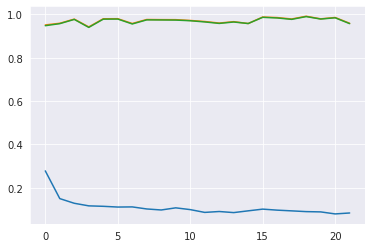

In [24]:
# plot losses
plt.plot(clf.history['loss'])

# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

# find and plot feature importance
y_pred = clf.predict(X_test)
# clf.feature_importances_
# feat_importances = pd.Series(clf.feature_importances_, index=data.columns)
# feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = clf.predict(X_test)
test_f1 = f1_score(preds, y_test, average = 'weighted')

# determine best accuracy for validation set
preds_valid = clf.predict(X_val)
valid_f1 = f1_score(preds_valid, y_val, average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_f1}")

In [25]:
print(y_pred)

[1 2 3 ... 0 1 1]


In [27]:
a = pd.DataFrame({'True': y_test, 'Predict': y_pred})
a

,True,Predict
0,1,1
1,2,2
2,3,3
3,2,2
4,0,0
...,...,...
35163,1,1
35164,1,1
35165,0,0
35166,2,1


In [24]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    f1_weighted = f1_score(preds_valid, y_val, average = 'weighted')

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

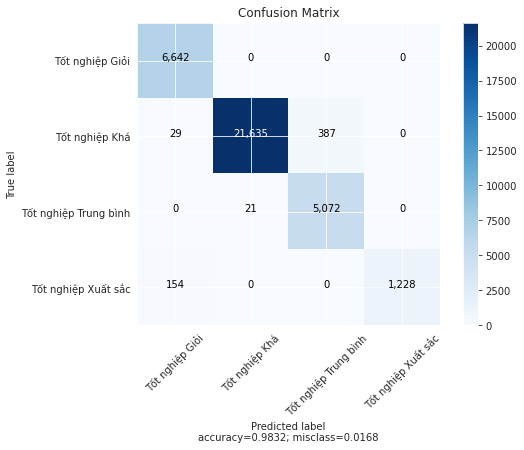

In [47]:
plot_confusion_matrix(cm           = confusion_matrix(y_pred, y_test),
                      normalize    = False,
                      target_names = ['Tốt nghiệp Giỏi', 'Tốt nghiệp Khá', 'Tốt nghiệp Trung bình', 'Tốt nghiệp Xuất sắc'],
                      title        = "Confusion Matrix")

In [48]:
saved_filename = clf.save_model('test_model_v1')

Successfully saved model at test_model_v1.zip


In [35]:
print(np.unique(y_test, return_counts = True))

(array([0, 1, 2, 3]), array([ 6825, 21656,  5459,  1228]))


In [38]:
test_data = data.iloc[-35168:]
test_data

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,diem_ts,hoc_ky,dkhk,tbhk,tctl,tbtl,xlhv,diem_tn,ket_qua_tn,nam_tn
140668,20074,3,1,0,3,3,21.777076,3,19,3.50,76.0,3.00,1,3.24,0,4.0
140669,20142,3,1,0,2,0,22.950000,3,24,3.63,92.0,3.56,1,3.49,0,4.0
140670,20152,3,1,0,1,0,22.000000,3,19,2.83,79.0,3.00,1,3.24,0,4.0
140671,20163,3,1,0,2,0,22.050000,3,12,2.00,60.0,2.53,1,2.56,1,4.5
140672,20131,3,0,1,0,0,20.200000,3,18,1.83,67.0,1.95,1,2.08,2,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175831,24330,6,1,0,0,3,25.000000,5,24,3.13,122.0,3.24,1,3.24,0,4.0
175832,24330,6,1,0,0,3,25.000000,6,3,2.33,131.0,3.18,1,3.24,0,4.0
175833,24331,6,1,0,0,3,24.250000,4,18,3.33,87.0,2.96,1,3.21,0,4.0
175834,24331,6,1,0,0,3,24.250000,5,21,3.57,108.0,3.09,1,3.21,0,4.0


In [39]:
test_data['ket_qua_tn'].value_counts()

1    21932
2     7413
0     4907
3      916
Name: ket_qua_tn, dtype: int64

In [41]:
## Test
X, y = train_test_split(data, test_size = 0.2, random_state = 0)
print(y.shape)

y1 = y.iloc[-35168:]
y['ket_qua_tn'].value_counts()

(35168, 16)


1    21465
0     6884
2     5529
3     1290
Name: ket_qua_tn, dtype: int64

In [43]:
X_, y_ = train_test_split(data, test_size = 0.2, random_state = 42)
print(y.shape)

y2 = y_.iloc[-35168:]
y2['ket_qua_tn'].value_counts()

(35168, 16)


1    21656
0     6825
2     5459
3     1228
Name: ket_qua_tn, dtype: int64

In [44]:
data['ket_qua_tn'].value_counts()

1    108092
0     33987
2     27558
3      6199
Name: ket_qua_tn, dtype: int64

## Model train với eval_metric 'f1_weighted'

BEST ACCURACY SCORE ON VALIDATION SET : 0.9404865978264833
BEST ACCURACY SCORE ON TEST SET : 0.9415223550561256


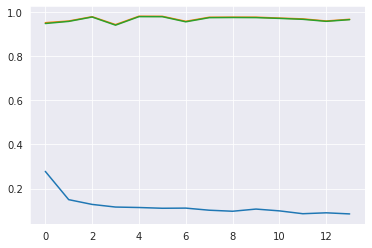

In [22]:
# plot losses
plt.plot(clf.history['loss'])

# plot accuracy
plt.plot(clf.history['train_f1_weighted'])
plt.plot(clf.history['valid_f1_weighted'])

# find and plot feature importance
y_pred = clf.predict(X_test)
# clf.feature_importances_
# feat_importances = pd.Series(clf.feature_importances_, index=data.columns)
# feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = clf.predict(X_test)
test_f1 = f1_score(preds, y_test, average = 'weighted')

# determine best accuracy for validation set
preds_valid = clf.predict(X_val)
valid_f1 = f1_score(preds_valid, y_val, average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_f1}")

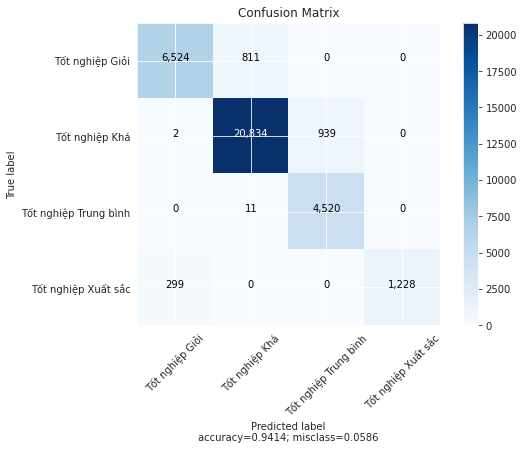

In [25]:
plot_confusion_matrix(cm           = confusion_matrix(y_pred, y_test),
                      normalize    = False,
                      target_names = ['Tốt nghiệp Giỏi', 'Tốt nghiệp Khá', 'Tốt nghiệp Trung bình', 'Tốt nghiệp Xuất sắc'],
                      title        = "Confusion Matrix")